### Word level labeling

In [1]:
import xml.etree.ElementTree as ET
from pathlib import Path
import re
import json
from difflib import SequenceMatcher
from tqdm import tqdm

GT_DIR = Path("../../data/d2_0001-0100_with_marginalia")
INPUT_DIR = Path("../../data/d2_0001-0100_without_marginalia")

def normalize_text(text):
    # Replace German umlauts and ß with ASCII equivalents
    umlaut_map = {
        'ä': 'a', 'ö': 'o', 'ü': 'u',
        'Ä': 'A', 'Ö': 'O', 'Ü': 'U'
    }
    for orig, repl in umlaut_map.items():
        text = text.replace(orig, repl)
    text = text.replace('\u00A0', ' ')
    text = text.strip().lower()
    text = re.sub(r'\s+', ' ', text)
    return text


def tokenize(text):
    text = text.replace('⸗', ' ').replace('-', ' ')
    return re.findall(r'\w+', text)

def line_similarity(line1_words, line2_words):
    if not line1_words or not line2_words:
        return 0.0
    line1_str = ' '.join(line1_words)
    line2_str = ' '.join(line2_words)
    return SequenceMatcher(None, line1_str, line2_str).ratio()

def get_gt_all_lines(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    gt_lines = []
    for tr in root.findall(".//{*}TextRegion"):
        region_type = tr.get("type", "").lower()
        region_id = tr.get("id", None)
        for line in tr.findall(".//{*}TextLine"):
            unicode_el = line.find(".//{*}Unicode")
            if unicode_el is not None and unicode_el.text:
                line_words = tokenize(unicode_el.text.strip())
                line_words_norm = [normalize_text(w) for w in line_words]
                gt_lines.append({
                    'region_type': region_type,
                    'region_id': region_id,
                    'line_id': line.get("id") if line is not None else None,
                    'text': unicode_el.text.strip(),
                    'words': line_words,
                    'words_norm': line_words_norm
                })
    return gt_lines

def get_gt_paragraph_lines(gt_lines):
    paragraphs = []
    para_map = {}
    for gl in gt_lines:
        if gl['region_type'] == "paragraph":
            para_id = gl['region_id']
            if para_id not in para_map:
                para_map[para_id] = []
            para_map[para_id].append(gl)
    for para_id, lines in para_map.items():
        paragraphs.append({'id': para_id, 'lines': lines})
    return paragraphs

def get_input_lines(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    lines = []
    for tr in root.findall(".//{*}TextRegion"):
        for line in tr.findall(".//{*}TextLine"):
            unicode_el = line.find(".//{*}Unicode")
            if unicode_el is not None and unicode_el.text:
                line_words = tokenize(unicode_el.text.strip())
                line_words_norm = [normalize_text(w) for w in line_words]
                lines.append({
                    'words': line_words,
                    'words_norm': line_words_norm,
                    'text': unicode_el.text.strip(),
                    'line_id': line.get("id") if line is not None else None,
                    'assigned_para': None,
                    'assigned_gt_line': None,
                    'similarity': 0.0,
                    'matched_to': None,  # can be 'paragraph', 'any_gt', or 'marginalia'
                })
    return lines

def get_marginalia_lines(gt_lines):
    # Return full marginalia GT lines for matching
    return [gl for gl in gt_lines if gl['region_type'] == "marginalia"]

def get_marginalia_phrases(gt_lines):
    phrases = []
    for gl in gt_lines:
        if gl['region_type'] == "marginalia":
            phrase = [normalize_text(w) for w in gl['words']]
            if phrase:
                phrases.append(phrase)
    return phrases

def match_phrase_at(idx, phrase, input_words):
    if idx + len(phrase) > len(input_words):
        return False
    for k in range(len(phrase)):
        if input_words[idx+k] != phrase[k]:
            return False
    return True

def assign_input_lines_to_gt(input_lines, gt_paragraphs, used_gt_line_ids):
    gt_lines_flat = []
    for para in gt_paragraphs:
        for line_idx, line in enumerate(para['lines']):
            if line['line_id'] in used_gt_line_ids:
                continue  # Exclude already used GT lines
            gt_lines_flat.append({
                'para_id': para['id'],
                'line_idx': line_idx,
                'line_data': line
            })
    for input_line in input_lines:
        if input_line['matched_to']:
            continue  # skip if already matched perfectly to marginalia or any_gt
        best_similarity = 0.0
        best_gt_line = None
        for gt_line in gt_lines_flat:
            similarity = line_similarity(input_line['words_norm'], gt_line['line_data']['words_norm'])
            if similarity > best_similarity:
                best_similarity = similarity
                best_gt_line = gt_line
        if best_gt_line and best_similarity > 0:
            input_line['assigned_para'] = best_gt_line['para_id']
            input_line['assigned_gt_line'] = best_gt_line['line_idx']
            input_line['similarity'] = best_similarity
            if best_similarity == 1.0:
                input_line['matched_to'] = 'paragraph'
        else:
            input_line['assigned_para'] = None
            input_line['assigned_gt_line'] = None
            input_line['similarity'] = 0.0

def match_with_context(word_idx, ref_words, ref_used, input_words):
    for ref_ptr in range(len(ref_words)):
        if ref_used[ref_ptr]:
            continue
        if input_words[word_idx] == ref_words[ref_ptr]:
            prev_match = (word_idx > 0 and ref_ptr > 0 and input_words[word_idx-1] == ref_words[ref_ptr-1])
            next_match = (word_idx < len(input_words)-1 and ref_ptr < len(ref_words)-1 and input_words[word_idx+1] == ref_words[ref_ptr+1])
            at_start = (word_idx == 0 or ref_ptr == 0)
            at_end = (word_idx == len(input_words)-1 or ref_ptr == len(ref_words)-1)
            if prev_match or next_match or at_start or at_end:
                return ref_ptr
    return -1

# ---- Main code ----

output = []

input_files = sorted(list(INPUT_DIR.glob("*.xml")))

for input_xml in tqdm(input_files, desc="Processing files"):
    file_stem = input_xml.stem
    gt_xml = GT_DIR / f"{file_stem}.xml"

    if not gt_xml.exists():
        print(f"GT file not found for {file_stem}, skipping")
        continue

    gt_lines = get_gt_all_lines(gt_xml)
    gt_paragraphs = get_gt_paragraph_lines(gt_lines)
    input_lines = get_input_lines(input_xml)
    marginalia_lines = get_marginalia_lines(gt_lines)
    marginalia_phrases = get_marginalia_phrases(gt_lines)

    # --- PHASE 0: Marginalia matching first ---
    marginalia_phrase_set = set(tuple(phrase) for phrase in marginalia_phrases if phrase)
    marginalia_line_ids = set()
    matched_marginalia_phrases = set()
    matched_input_line_ids = set()

    for marg_gt in marginalia_lines:
        marg_tuple = tuple(marg_gt['words_norm'])
        for input_line in input_lines:
            if input_line['matched_to']:
                continue
            if tuple(input_line['words_norm']) == marg_tuple:
                input_line['matched_to'] = 'marginalia'
                matched_marginalia_phrases.add(marg_tuple)
                matched_input_line_ids.add(input_line['line_id'])
                marginalia_line_ids.add(input_line['line_id'])
                break  # Each marginalia GT can be matched to at most one input line

    # --- PHASE 1: Paragraph assignment ---
    used_gt_line_ids = set()
    for input_line in input_lines:
        if input_line['matched_to'] == 'marginalia':
            continue
    assign_input_lines_to_gt(input_lines, gt_paragraphs, used_gt_line_ids)
    for input_line in input_lines:
        if input_line['similarity'] == 1.0 and input_line['assigned_para'] is not None:
            para = next(p for p in gt_paragraphs if p['id'] == input_line['assigned_para'])
            gt_line = para['lines'][input_line['assigned_gt_line']]
            used_gt_line_ids.add(gt_line['line_id'])
            input_line['matched_to'] = 'paragraph'
            matched_input_line_ids.add(input_line['line_id'])

    # --- PHASE 2: Try to match to any GT line for remaining lines ---
    gt_lines_by_wordsnorm = {tuple(gl['words_norm']): gl for gl in gt_lines}
    for input_line in input_lines:
        if input_line['matched_to']:
            continue
        words_norm_tuple = tuple(input_line['words_norm'])
        gt_line = gt_lines_by_wordsnorm.get(words_norm_tuple, None)
        if gt_line and gt_line['line_id'] not in used_gt_line_ids:
            input_line['matched_to'] = 'any_gt'
            used_gt_line_ids.add(gt_line['line_id'])
            matched_input_line_ids.add(input_line['line_id'])

    # --- LABELING ---
    line_wordlabels = {}  # line_id -> list of (word, label)
    para_id_map = {}      # line_id -> para_id

    # PHASE A: Label all perfectly matched input lines as "correct"
    for input_line in input_lines:
        if input_line['matched_to'] in ('marginalia', 'paragraph', 'any_gt'):
            para_id = input_line.get('assigned_para') or input_line.get('para_id') or ""
            para_id_map[input_line['line_id']] = para_id
            line_wordlabels[input_line['line_id']] = [(w, "correct") for w in input_line['words']]

    # PHASE B: Process other input lines by paragraph for context and marginalia-inside-line
    for para in gt_paragraphs:
        para_gt_words = []
        for line in para['lines']:
            if line['line_id'] not in used_gt_line_ids:
                para_gt_words.extend(line['words_norm'])
        for input_line in [l for l in input_lines if l['assigned_para'] == para['id'] and l['line_id'] not in matched_input_line_ids]:
            input_words = input_line['words']
            input_words_norm = input_line['words_norm']
            input_line_id = input_line['line_id']
            para_id_map[input_line_id] = para['id']
            labels = ["unmatched"] * len(input_words)
            # First: marginalia-inside-line (error marking, skip those matched 100%)
            for phrase in marginalia_phrases:
                phrase_tuple = tuple(phrase)
                if phrase_tuple in matched_marginalia_phrases:
                    continue  # Already matched 100%
                if len(phrase) == 1:
                    for i, word in enumerate(input_words_norm):
                        if labels[i] == "unmatched" and word == phrase[0]:
                            labels[i] = "error"
                elif len(phrase) > 1:
                    for i in range(len(input_words_norm) - len(phrase) + 1):
                        if all(labels[i+k] == "unmatched" for k in range(len(phrase))) and match_phrase_at(i, phrase, input_words_norm):
                            if input_line_id in marginalia_line_ids:
                                continue
                            for k in range(len(phrase)):
                                labels[i+k] = "error"
            # Second: context word matching
            para_gt_used = [False] * len(para_gt_words)
            for i, word in enumerate(input_words_norm):
                if labels[i] != "unmatched":
                    continue
                gt_idx = match_with_context(i, para_gt_words, para_gt_used, input_words_norm)
                if gt_idx != -1:
                    labels[i] = "correct"
                    para_gt_used[gt_idx] = True
            line_wordlabels[input_line_id] = [(w, l) for w, l in zip(input_words, labels)]

    # PHASE C: All other input lines not matched yet
    for input_line in input_lines:
        if input_line['line_id'] in line_wordlabels:
            continue  # Already processed
        input_words = input_line['words']
        input_words_norm = input_line['words_norm']
        input_line_id = input_line['line_id']
        para_id = input_line.get('assigned_para') or input_line.get('para_id') or ""
        para_id_map[input_line_id] = para_id
        if input_line['matched_to'] == 'marginalia':
            labels = ["correct"] * len(input_words)
        else:
            labels = ["unmatched"] * len(input_words)
            for phrase in marginalia_phrases:
                phrase_tuple = tuple(phrase)
                if phrase_tuple in matched_marginalia_phrases:
                    continue
                if len(phrase) == 1:
                    for i, word in enumerate(input_words_norm):
                        if labels[i] == "unmatched" and word == phrase[0]:
                            labels[i] = "error"
                elif len(phrase) > 1:
                    for i in range(len(input_words_norm) - len(phrase) + 1):
                        if all(labels[i+k] == "unmatched" for k in range(len(phrase))) and match_phrase_at(i, phrase, input_words_norm):
                            if input_line_id in marginalia_line_ids:
                                continue
                            for k in range(len(phrase)):
                                labels[i+k] = "error"
        line_wordlabels[input_line_id] = [(w, l) for w, l in zip(input_words, labels)]

    # ---- POSTPROCESS: label all unmatched as error ----
    for line_id in line_wordlabels:
        line_wordlabels[line_id] = [(w, "error" if l == "unmatched" else l) for w, l in line_wordlabels[line_id]]

    # ---- WRITE OUTPUT ----
    for input_line in input_lines:
        line_id = input_line['line_id']
        para_id = para_id_map.get(line_id, "")
        for word, label in line_wordlabels[line_id]:
            output.append({
                "file_id": file_stem,
                "para_id": para_id,
                "line_id": line_id,
                "word": word,
                "label": label
            })

with open("../../data/word_level_labels.jsonl", "w", encoding="utf-8") as f:
    for row in output:
        f.write(json.dumps(row, ensure_ascii=False) + "\n")

print(f"\nSaved {len(output)} word-level labeled examples to word_level_labels.jsonl")

Processing files:   1%|          | 4/493 [00:01<02:36,  3.12it/s]

Processing files: 100%|██████████| 493/493 [01:21<00:00,  6.03it/s]



Saved 159219 word-level labeled examples to word_level_labels.jsonl


### Display the results on a specific page

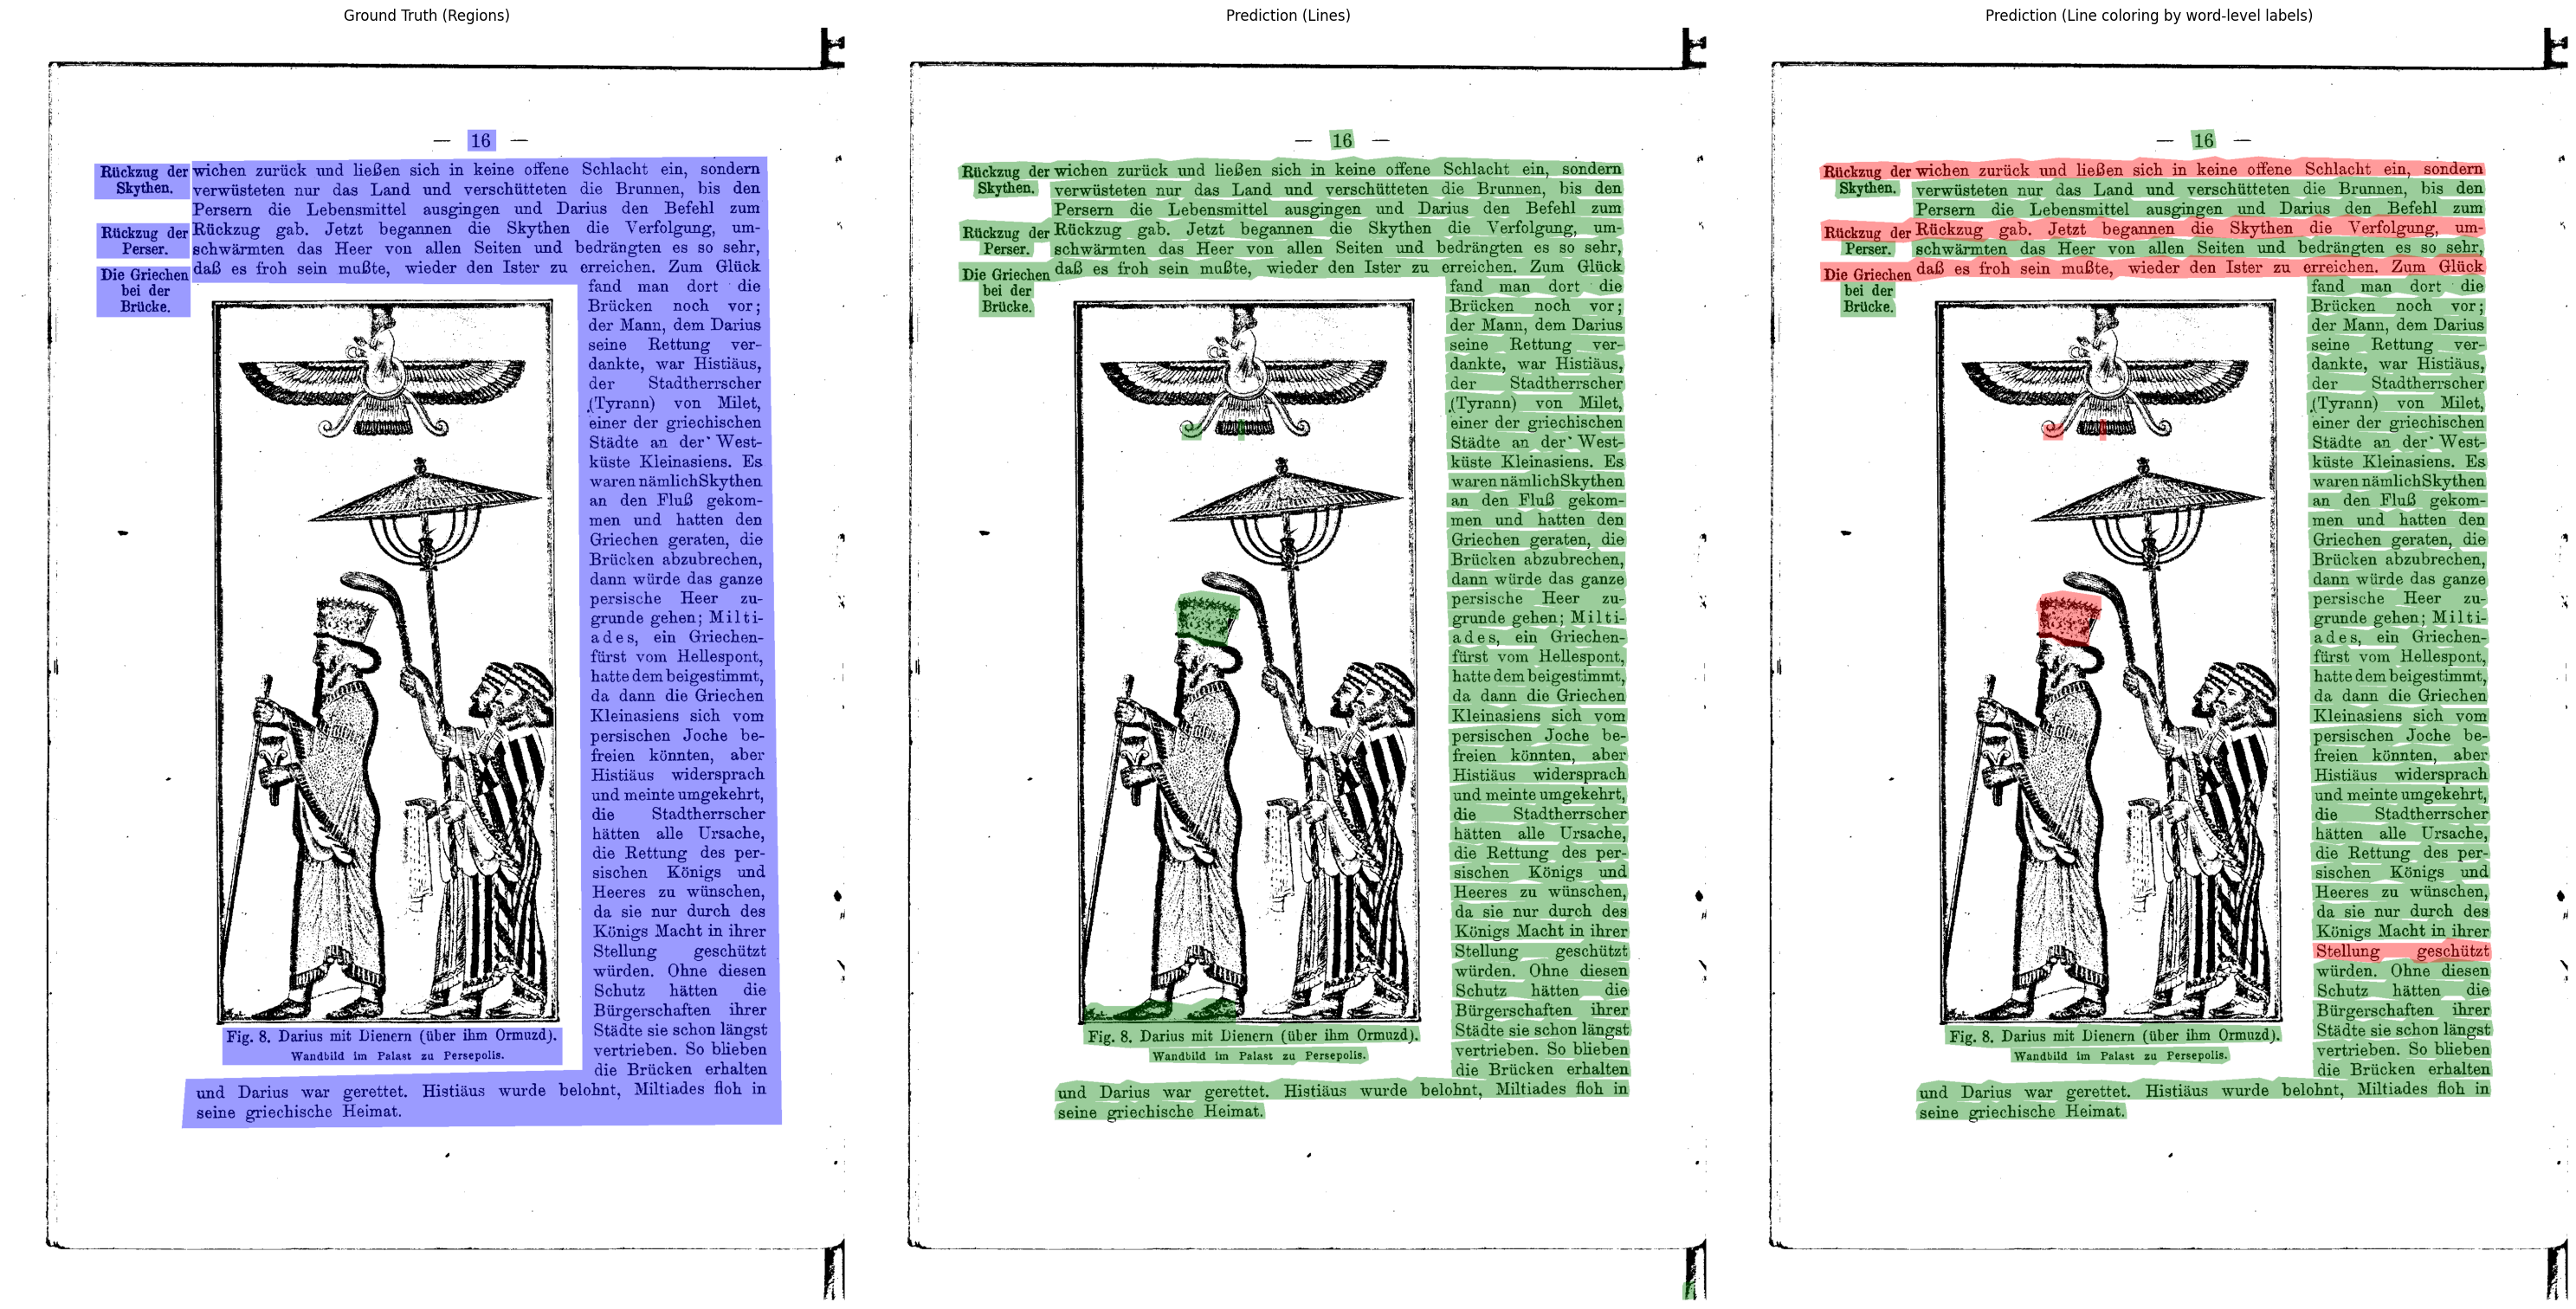

Displayed GT, Prediction (line-level), and word-level highlighted images for file: 1724666584_00000024
  Red lines: 8 (contain 'error' words)
  Green lines: 52 (all words correct)
  Orange lines: 0 (all words unmatched)


In [1]:
import json
from collections import defaultdict
from pathlib import Path
from PIL import Image, ImageDraw, ImageColor
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

def parse_pagexml_polygons(xml_path: Path):
    ns = {"pg": "http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15"}
    root = ET.parse(xml_path).getroot()
    polygons, types = [], []
    for region in root.findall(".//pg:TextRegion", ns):
        region_type = region.attrib.get("type", "").lower()
        coords = region.find("pg:Coords", ns)
        if coords is None:
            continue
        pts = [tuple(map(int, p.split(","))) for p in coords.attrib["points"].split() if "," in p]
        if pts:
            polygons.append(pts)
            types.append(region_type)
    return polygons, types

def load_line_labels(jsonl_path, file_id):
    line_labels = defaultdict(list)
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            if obj["file_id"] == file_id:
                line_labels[obj["line_id"]].append(obj["label"])
    return line_labels

def classify_lines(line_labels):
    classified = defaultdict(set)
    for line_id, labels in line_labels.items():
        label_set = set(labels)
        if "error" in label_set:
            classified['red'].add(line_id)
        elif all(l == "correct" for l in labels):
            classified['green'].add(line_id)
        elif all(l == "unmatched" for l in labels):
            classified['orange'].add(line_id)
    return classified

def get_textline_polygons_by_id(xml_path: Path):
    ns = {'pg': 'http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15'}
    root = ET.parse(xml_path).getroot()
    line_polygons = {}
    for line in root.findall('.//pg:TextLine', ns):
        line_id = line.attrib.get("id", "")
        coords_elem = line.find('pg:Coords', ns)
        if coords_elem is None:
            continue
        pts = [tuple(map(int, p.split(","))) for p in coords_elem.attrib["points"].split() if "," in p]
        if pts:
            line_polygons[line_id] = pts
    return line_polygons

def draw_polygons(image_path: Path, polygons, color="red", opacity=100) -> Image.Image:
    img = Image.open(image_path).convert("RGBA")
    overlay = Image.new("RGBA", img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay, "RGBA")
    rgba = ImageColor.getrgb(color) + (opacity,)
    for poly in polygons:
        draw.polygon(poly, fill=rgba)
    img.alpha_composite(overlay)
    return img

def draw_polygons_on_img(img: Image.Image, polygons, color="red", opacity=100):
    overlay = Image.new("RGBA", img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay, "RGBA")
    rgba = ImageColor.getrgb(color) + (opacity,)
    for poly in polygons:
        draw.polygon(poly, fill=rgba)
    img.alpha_composite(overlay)
    return img

def visualize_gt_pred_and_word_labels(
    gt_image_path: Path,
    gt_xml_path: Path,
    pred_image_path: Path,
    pred_xml_path: Path,
    word_label_jsonl_path: Path,
    base_name: str,
):
    gt_polygons, gt_types = parse_pagexml_polygons(gt_xml_path)
    gt_img = draw_polygons(gt_image_path, gt_polygons, color="blue", opacity=100)

    pred_line_polygons = get_textline_polygons_by_id(pred_xml_path)
    line_poly_list = list(pred_line_polygons.values())
    pred_img = draw_polygons(pred_image_path, line_poly_list, color="green", opacity=100)

    line_labels = load_line_labels(word_label_jsonl_path, base_name)
    classified = classify_lines(line_labels)

    line_polygons = get_textline_polygons_by_id(pred_xml_path)
    color2poly = {color: [line_polygons[lid] for lid in lids if lid in line_polygons]
                  for color, lids in classified.items()}

    word_img = Image.open(pred_image_path).convert("RGBA")
    draw_polygons_on_img(word_img, color2poly.get("orange", []), color="orange", opacity=200)
    draw_polygons_on_img(word_img, color2poly.get("green", []), color="green", opacity=100)
    draw_polygons_on_img(word_img, color2poly.get("red", []), color="red", opacity=100)

    fig, axs = plt.subplots(1, 3, figsize=(30, 15))
    axs[0].imshow(gt_img)
    axs[0].set_title("Ground Truth (Regions)")
    axs[0].axis("off")

    axs[1].imshow(pred_img)
    axs[1].set_title("Prediction (Lines)")
    axs[1].axis("off")

    axs[2].imshow(word_img)
    axs[2].set_title('Prediction (Line coloring by word-level labels)')
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

    print(
        f"Displayed GT, Prediction (line-level), and word-level highlighted images for file: {base_name}\n"
        f"  Red lines: {len(color2poly.get('red', []))} (contain 'error' words)\n"
        f"  Green lines: {len(color2poly.get('green', []))} (all words correct)\n"
        f"  Orange lines: {len(color2poly.get('orange', []))} (all words unmatched)"
    )

# --- Usage example ---
base_name = "1724666584_00000024"
# base_name = "173736378X_00000100"
# base_name = "173736378X_00000051"
# base_name = "174170569X_00000011"
# base_name = "174170569X_00000022"
# base_name = "1740388542_00000039"
# base_name = "173736378X_00000128"

visualize_gt_pred_and_word_labels(
    gt_image_path=Path(f"../../data/d2_0001-0100_with_marginalia/{base_name}.bin.png"),
    gt_xml_path=Path(f"../../data/d2_0001-0100_with_marginalia/{base_name}.xml"),
    pred_image_path=Path(f"../../data/d2_0001-0100_without_marginalia/{base_name}.bin.png"),
    pred_xml_path=Path(f"../../data/d2_0001-0100_without_marginalia/{base_name}.xml"),
    word_label_jsonl_path=Path("../../data/word_level_labels.jsonl"),
    base_name=base_name,
)